In [73]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [74]:
# img_id = '15_nir_2010-08-14'
# img_id = '18_nir_2015-08-14'
# img_id = '20_nir_2009-07-23'
# img_id = '24_nir_2012-07-11'
# img_id = '45_nir_2015-08-14'
# img_id = '46_nir_2014-07-10'
# img_id = '55_nir_2010-08-25'
# img_id = '27_nir_2014-07-10'
# img_id = '31_nir_2012-06-19'
# img_id = '64_nir_2013-08-11'
img_id = '73_nir_2013-08-11'
# img_id = '81_nir_2016-08-03'
filein = '../fields_raw_nice/' + img_id + '.png'


In [75]:
def plot_lines(lines):
    for line_idx in range(len(lines)):
        line = lines[line_idx][0]
        rho, theta = (line[0],line[1])
        costh = np.cos(theta)
        sinth = np.sin(theta)
        x0 = rho*costh
        y0 = rho*sinth
        c = 500
        x1 = int(x0 - c*sinth)
        y1 = int(y0 + c*costh)
        x2 = int(x0 + c*sinth)
        y2 = int(y0 - c*costh)

        plt.plot([x1,x2],[y1,y2],'y')

In [76]:
# Load raw image, convert to grayscale
img = cv2.imread(filein)
gray_raw = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

## Load raw image, normalize, saturate, denoise

In [77]:
# Normalized
edge = 0
b, t = np.nanpercentile(gray_raw, [edge, 100 - edge])
gray_norm = 255*(gray_raw - b) / (t - b)

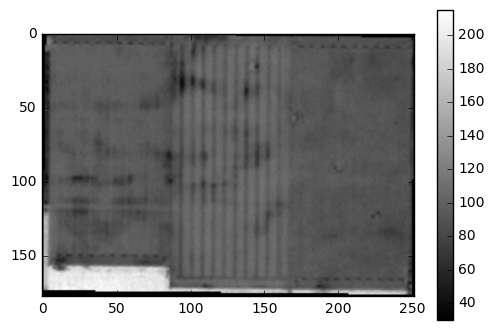

In [78]:
plt.imshow(gray_raw,cmap=matplotlib.cm.get_cmap('gray'))
plt.colorbar()
plt.show()

In [79]:
# For plotting, Replace min with nans
gray_nan = gray_norm.copy()
gray_nan[np.where(gray_nan==np.min(gray_nan))] = np.nan
# gray_nan[np.where(gray_nan==np.min(gray_nan))]

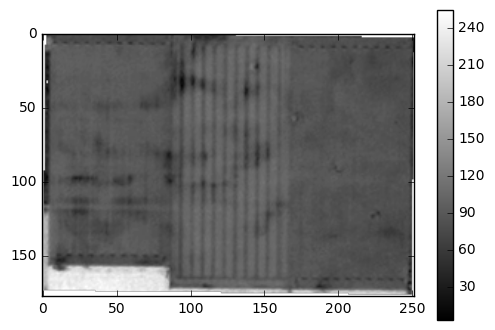

In [80]:
plt.imshow(gray_nan,cmap=matplotlib.cm.get_cmap('gray'))
plt.colorbar()
plt.show()

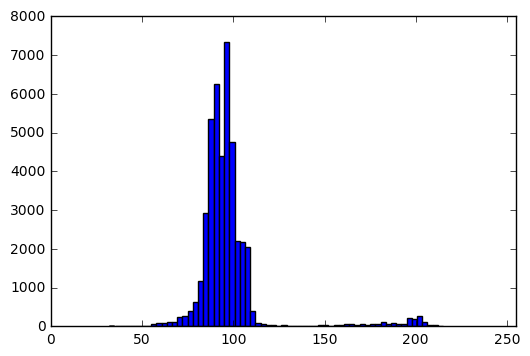

In [81]:
# Plot histogram of values excluding min values

gray_nonzr = np.ravel(gray_raw[np.where(gray_raw!=np.min(gray_raw))])
gray_vec = np.ravel(gray_nonzr)
# gray_vec = gray_vec[~np.isnan(gray_vec)]
plt.hist(gray_vec,64)
plt.xlim(0,255)
plt.show()

In [82]:
# Saturate scale based on percentiles
edge = 5  # percent
b, t = np.percentile(gray_vec, [edge, 100 - edge])

gray_sat = gray_raw.copy()
gray_sat[np.where(gray_sat<b)] = b
gray_sat[np.where(gray_sat>t)] = t

In [83]:
b,t

(81.0, 112.0)

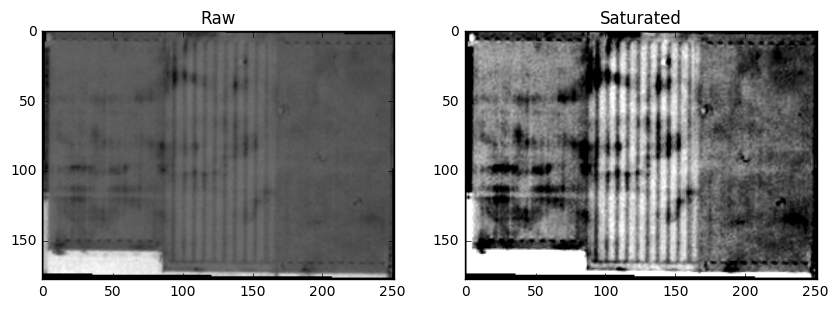

In [84]:
# Plot original and saturated images
plt.figure(figsize=(10, 20))

plt.subplot(1,2,1)
plt.imshow(gray_raw,cmap=matplotlib.cm.get_cmap('gray'))
# plt.colorbar()
plt.title('Raw')

plt.subplot(1,2,2)
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
# plt.colorbar()
plt.title('Saturated')

plt.show()

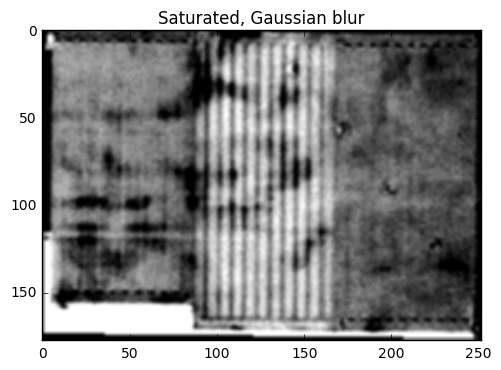

In [85]:
# Gaussian blur?
blur = cv2.GaussianBlur(gray_sat,(3,3),0)
plt.imshow(blur,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Saturated, Gaussian blur')
plt.show()

## Thresholding

In [86]:
# Try some thresholding

# # On raw image
# thr_val_raw = np.median(gray_raw)
# ret,thr_raw = cv2.threshold(gray_raw,thr_val_raw,255,cv2.THRESH_BINARY)

# Binary on saturated image
thr_val_sat = np.median(gray_sat)
ret,thr_sat = cv2.threshold(gray_sat,thr_val_sat,255,cv2.THRESH_BINARY)

# Binary On saturated + Gaussian blur
thr_val_blur = np.median(blur)
ret,thr_blur = cv2.threshold(blur,thr_val_blur,255,cv2.THRESH_BINARY)

# Adaptive on saturated image
thr_ad = cv2.adaptiveThreshold(gray_sat,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,0)

# Adaptive on saturated + Gaussian blur
thr_ad_blur = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,0)


# ret,thr = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)


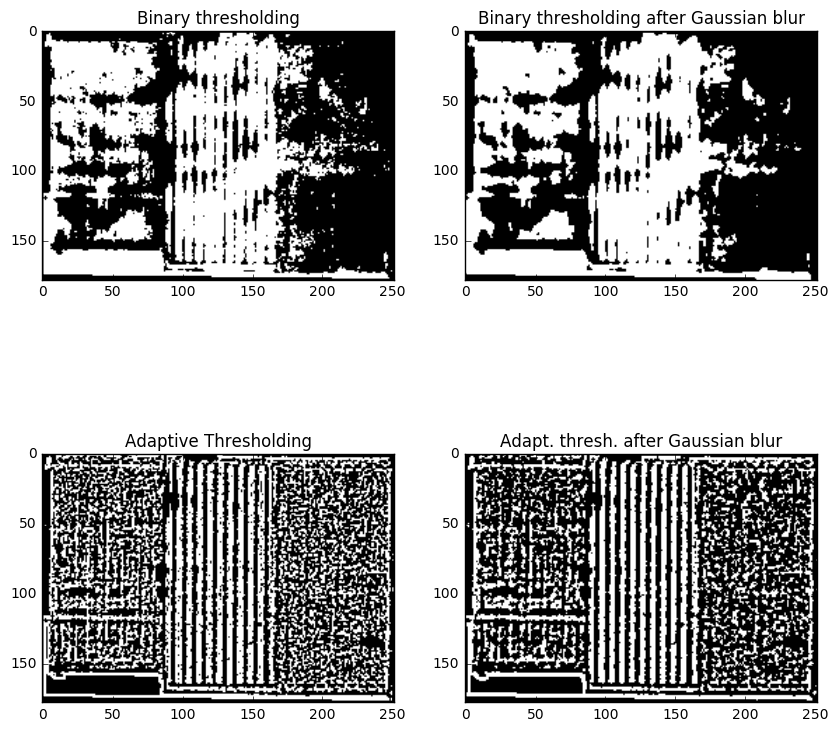

In [87]:
# Plot thresholded image
plt.figure(figsize=(10, 10))

plt.subplot(2,2,1)
plt.imshow(thr_sat,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Binary thresholding')

plt.subplot(2,2,2)
plt.imshow(thr_blur,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Binary thresholding after Gaussian blur')

plt.subplot(2,2,3)
plt.imshow(thr_ad,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Adaptive Thresholding')

plt.subplot(2,2,4)
plt.imshow(thr_ad_blur,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Adapt. thresh. after Gaussian blur')

plt.show()

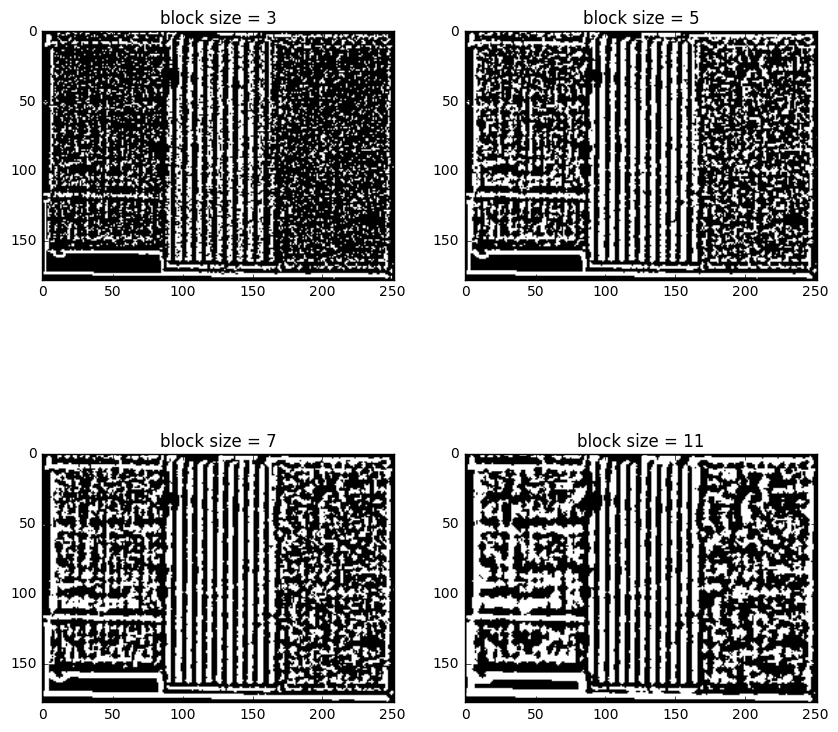

In [88]:
# Adaptive thresholding for different block sizes

thr_ad_blur_1 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,3,0)
thr_ad_blur_2 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,0)
thr_ad_blur_3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,7,0)
thr_ad_blur_4 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,0)

plt.figure(figsize=(10, 10))

plt.subplot(2,2,1)
plt.imshow(thr_ad_blur_1,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('block size = 3')

plt.subplot(2,2,2)
plt.imshow(thr_ad_blur_2,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('block size = 5')

plt.subplot(2,2,3)
plt.imshow(thr_ad_blur_3,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('block size = 7')

plt.subplot(2,2,4)
plt.imshow(thr_ad_blur_4,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('block size = 11')

plt.show()


## Edge detection

In [89]:
# Edge detection on binary image (adaptive threshold after Gaussian blur)

# edges_sat = cv2.Canny(gray_sat,50,150,apertureSize = 3)
# edges_thr = cv2.Canny(thr_sat,50,150,apertureSize = 3)

edges_ad_thr = cv2.Canny(thr_ad_blur,100,150,apertureSize = 5)



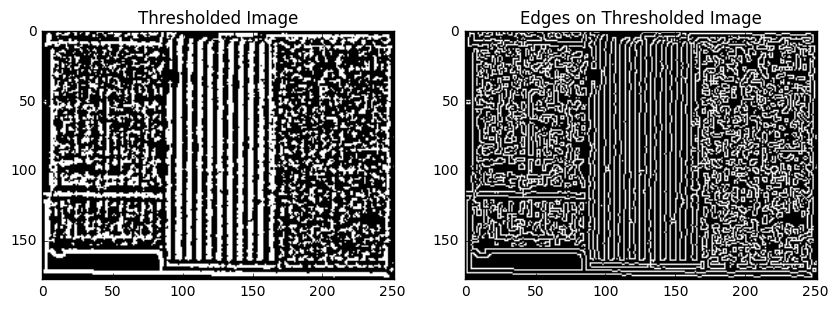

In [90]:
# Plot detected eges on original and saturated images
plt.figure(figsize=(10, 20))

# plt.subplot(1,2,1)
# plt.imshow(edges_sat,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('Edges on Saturated Image')

# plt.subplot(1,2,2)
# plt.imshow(edges_thr,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('Edges on Thresholded Image')

plt.subplot(1,2,1)
plt.imshow(thr_ad_blur,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Thresholded Image')

plt.subplot(1,2,2)
plt.imshow(edges_ad_thr,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Edges on Thresholded Image')

plt.show()

## Line detection

For ROUGH direction detection:
If dominant line direction is NS-EW, then set 2nd threshold to 0.5 to avoid picking diagonal lines

But, if the image has diagonal lines, need to increase 2nd threshold to 1

In [118]:
# Line detection on binary image itself
lines_thr = cv2.HoughLines(thr_ad_blur,0.7,1*np.pi/180,130)
len(lines_thr)

31

In [92]:
# Nlines = []
# thresholds = range(70,100,10)
# for threshold in thresholds:
#     lines_thr = cv2.HoughLines(thr_ad_blur,0.5,1*np.pi/180,threshold)
#     Nlines.append(len(lines_thr))
# Nlines = np.array(Nlines)
# thresholds = np.array(thresholds)

In [93]:
# plt.plot(thresholds,Nlines,'.-')
# plt.show()

In [110]:
# Line detection on edges 
lines_edges = cv2.HoughLines(edges_ad_thr,0.5,1*np.pi/180,110)
len(lines_edges)

19

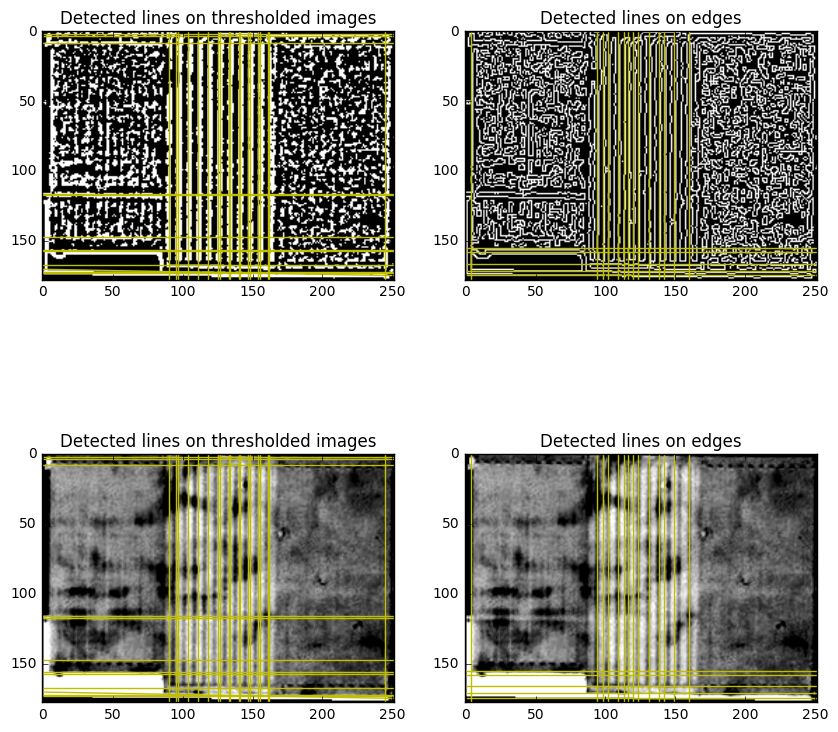

In [119]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.imshow(thr_ad_blur,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Detected lines on thresholded images')
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plot_lines(lines_thr)
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)

plt.subplot(222)
plt.imshow(edges_ad_thr,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Detected lines on edges')
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plot_lines(lines_edges)
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)

plt.subplot(223)
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Detected lines on thresholded images')
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plot_lines(lines_thr)
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)

plt.subplot(224)
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Detected lines on edges')
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plot_lines(lines_edges)
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)


plt.show()


Feature exraction
orientation, spacing, others...

Find features that naturally cluster in true and false detections

clustering -->
* get ensemble average of features
* possible features: lines packed closed together: 2 lines bounding each stripe
* correlate with dominant angle from line segments?
* repetability! not isolation

Do clustering to get labels (hand label)

Train a classifier using those labels and (same?) features: like KNN, random forest, decision tree

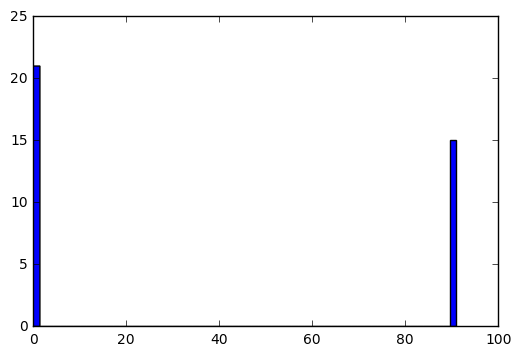

In [117]:
# Start with simple features such as rho and theta, centroid
angles = lines_thr.squeeze()[:,1]*180/np.pi
plt.hist(angles,64)
plt.show()


## Line segment detection

In [97]:
# Probabilistic Hough transform (detects line segments)

minLineLength = 20
maxLineGap = 1
lines_pr = cv2.HoughLinesP(thr_ad_blur,1,np.pi/180,10,minLineLength,maxLineGap)
# lines_pr = cv2.HoughLinesP(edges_ad_thr,1,np.pi/180,50,minLineLength,maxLineGap)
len(lines_pr)

2426

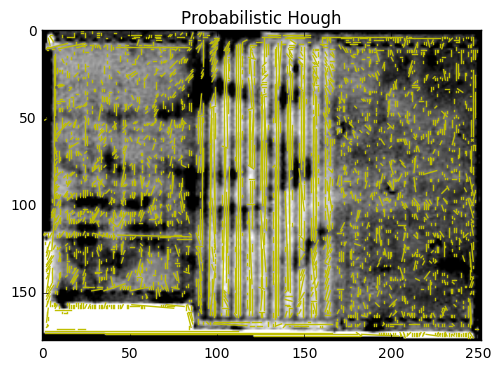

In [98]:
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Probabilistic Hough')
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
# plot_lines(lines_pr)
for line_idx in range(len(lines_pr)):
    line = lines_pr[line_idx][0]
    plt.plot([line[0],line[2]],[line[1],line[3]],'y')
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)
plt.show()

In [99]:
thetas_pr = []
lengths_pr = []
for line in lines_pr.squeeze():
    x1 = line[0]
    y1 = line[1]
    x2 = line[2]
    y2 = line[3]
    theta = np.arctan2(y2-y1,x2-x1)*180/ np.pi
    thetas_pr.append(theta)
    length = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    lengths_pr.append(length)
thetas_pr = np.array(thetas_pr)
lengths_pr = np.array(lengths_pr)


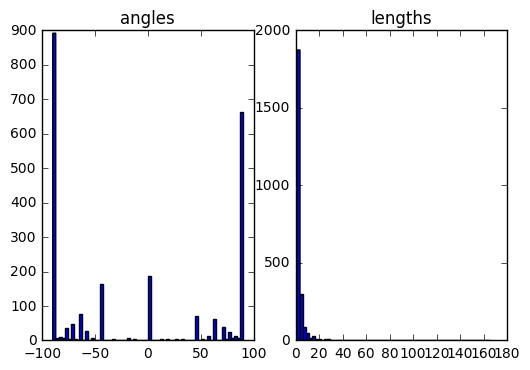

In [100]:
plt.figure
plt.subplot(121)
plt.hist(thetas_pr,64)
plt.title('angles')

plt.subplot(122)
plt.hist(lengths_pr,64)
plt.title('lengths')

plt.show()


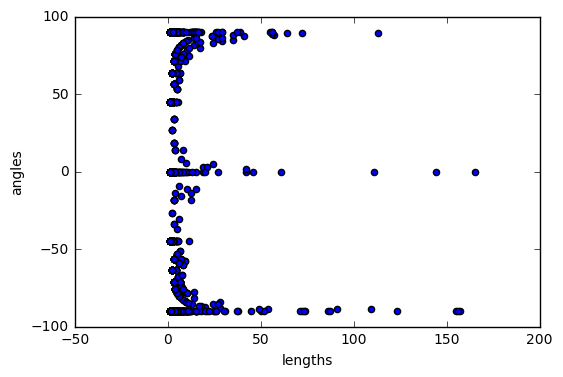

In [101]:
# This could be used to pick dominant angles given a threshold on line length
plt.scatter(lengths_pr,thetas_pr)
plt.xlabel('lengths')
plt.ylabel('angles')
plt.show()

In [102]:
# Systematically explore thresholds. Somehow select threshold automatically

In [103]:
# extract features from detected lines, cluster analysis

## Contouring / shape detection

In [104]:
contour_img = thr_ad_blur.copy()
contours = cv2.findContours(contour_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [105]:
len(contours[1])

610

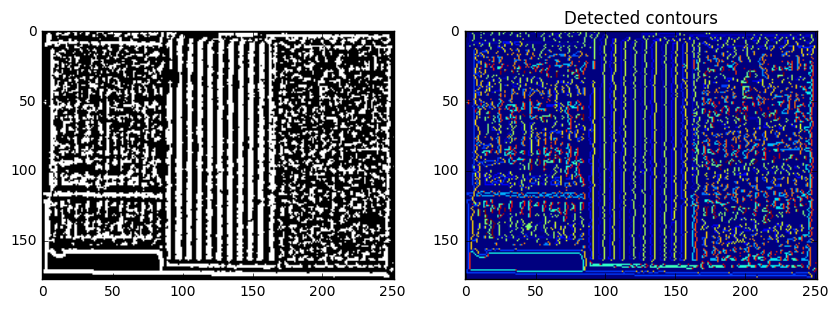

In [106]:
contoured = cv2.drawContours(contour_img, contours[1], 70, (128,255,0), 3)

plt.figure(figsize=(10, 10))

plt.figure
plt.subplot(121)
plt.imshow(thr_ad_blur,cmap=matplotlib.cm.get_cmap('gray'))

plt.subplot(122)
plt.imshow(contoured)
plt.title('Detected contours')
plt.show()

Contouring doesn't seem to work